In [1]:

import numpy as np
from astropy.io import fits, ascii
from astropy.table import Table
import pandas as pd
import matplotlib.pyplot as plt
import glob
import splat
from popsims.relations import polynomial_relation
from splat.photometry import filterMag
import splat.empirical as spe
from tqdm import tqdm
import popsims
from popsims.plot_style import  plot_style
from astropy.coordinates import SkyCoord, Galactic
import astropy.units as u
from matplotlib.lines import Line2D
plot_style()
%matplotlib inline



Welcome to the Spex Prism Library Analysis Toolkit (SPLAT)!
If you make use of any features of this toolkit for your research, please remember to cite the SPLAT paper:

Burgasser et al. (2017, Astro. Soc. India Conf. Series 14, p. 7); Bibcode: 2017ASInC..14....7B

If you make use of any spectra or models in this toolkit, please remember to cite the original source.
Please report any errors are feature requests to our github page, https://github.com/aburgasser/splat/




In [7]:
SURVEY_AREAS= {
       'Roman HLWAS': 2_000*u.degree**2,
       'Roman HLTDS': 20*u.degree**2 ,
}

#filenames --> redo with grisms and right exposur times
FILENAMES={'Roman HLWAS':'roman_hlwas',  'Roman HLTDS': 'roman_hltds'}

#add additional selection
SURVEY_DEPTHS= {
       'Roman HLWAS': {'WFI_J129': 26.7},
       'Roman HLTDS': {'WFI_J129': 26.7},
}


linestyles={'thin disk': '-', 'thick disk': '-.', 'halo': 'dotted'}
scl={'thin disk': 1, 'thick disk': 0.12, 'halo':0.005}


selection0="WFI_Z087 < 27.0 and WFI_Y106 < 27.0 and WFI_J129 < 27"
proper_motion_cuts= 'proper_motion > 5e-3'

selection= selection0+'and '+ proper_motion_cuts


In [8]:
def compute_vols_and_numbers(data, population, area, selection=None):
    counts={}
    selection_function={}
    pointings=list(data['volume'][population][0].keys())
    drho=(area/len(data['footprint'])).to(u.radian**2)
    sptgrid=data['sptgrid']
    
    for idx, spt in enumerate(sptgrid):
        #compute selection correction by pointing
        n=0.0
        slfx={}
        for p in pointings:
            #compute simulated number of types
            select='spt >{} and spt < {}'.format(spt, spt+0.9)
            
            #compute local density (only depends on type)
            lcdens=(df.scale*len(df.query(select))).mean()
            
            #select on pointing
            #print (p)
            select= select+'and '+'pointing == {}'.format(p)
            nsim=len(df.query(select))
            
            #add additional_selection
            if selection is not None:
                select = select+'and '+ selection
                
            nselected= len(df.query(select))
            #compute total selection function
            
            tot_selection=(nselected/nsim)
            v=data['volume'][population][idx][p]*tot_selection*lcdens*drho
            
            n += v.value
            slfx.update({p: tot_selection})
            
    
        counts.update({spt: {'number':n}})
        selection_function.update({spt: slfx})
        
    fn=pd.DataFrame.from_records(counts).T
    fn['spt']=sptgrid
    return fn, selection_function


In [9]:
data_dicts={}
for k in FILENAMES.keys():
    data=np.array(np.load('../simulations{}.npy'.format(FILENAMES[k]),allow_pickle=True)).flatten()[0]
    #compute 
    df=data['data']
    df['proper_motion']=(df.mu_delta**2+df.mu_alpha_cosdec**2)**0.5 #proper motion in mas/yr
    df['parallax']= 1000/df.distance
    data['data']=df
    data_dicts[k]= data
    


NameError: name 'selection10year' is not defined

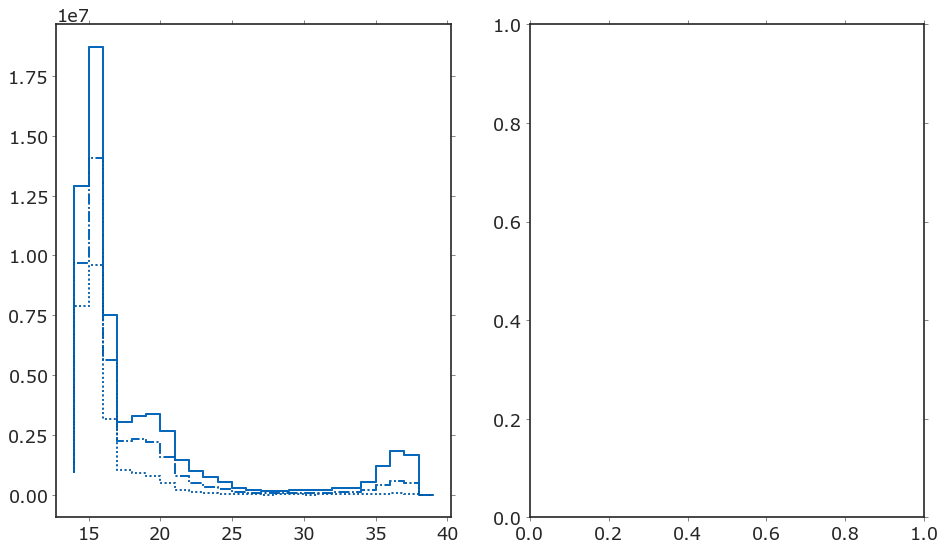

In [10]:
fig, ax=plt.subplots(ncols=2, figsize=(14, 8))
survey='Roman HLWAS'
for pop in ['thin disk', 'thick disk', 'halo']:
    f= scl[pop]
    ns=compute_vols_and_numbers(data, pop, SURVEY_AREAS[survey],selection=selection0)[0]
    ns0=compute_vols_and_numbers(data,pop, SURVEY_AREAS[survey], selection=selection)[0]
    ax[0].step(ns.spt, f*ns.number, linestyle=linestyles[pop], color='k')
    ax[0].step(ns0.spt, f*ns0.number,  linestyle=linestyles[pop], color='#0074D9')

survey='Roman HLTDS'
for pop in ['thin disk', 'thick disk', 'halo']:
    f= scl[pop]
    ns=compute_vols_and_numbers(data, pop, SURVEY_AREAS[survey],selection=selection0)[0]
    ns0=compute_vols_and_numbers(data,pop, SURVEY_AREAS[survey],selection=selection10year)[0]
    ax[1].step(ns.spt, f*ns.number, linestyle=linestyles[pop], color='k')
    ax[1].step(ns0.spt, f*ns0.number,  linestyle=linestyles[pop], color='#0074D9')

for a in ax:
    a.set(xticks=[15,20, 25, 30, 35], xticklabels=['M5', 'L0', 'L5', 'T0', 'T5'],\
          xlim=[14, 40], yscale='log', ylabel='Number Counts')
    
    legend_elements = [Line2D([0], [0], color='#0074D9', ls='-',lw=2, label='Thin Disk + Selection'),
                       Line2D([0], [0], color='#0074D9', ls='-.',lw=2, label='Thick Disk + Selection'),
                       Line2D([0], [0], color='#0074D9', ls='dotted',lw=2, label='Halo + Selection'),
                       Line2D([0], [0], color='k', ls='-',lw=2, label='Thin Disk'),
                       Line2D([0], [0], color='k', ls='-.',lw=2, label='Thick Disk '),
                       Line2D([0], [0], color='k', ls='dotted',lw=2, label='Halo ')]

    a.legend(handles=legend_elements, loc='upper right', fontsize=14)

ax[0].set_title('Roman HLWAS')
ax[1].set_title('Roman HLTDS')
plt.savefig('../figures/roman_baseline_number.pdf')